# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import tensorflow as tf
from utils import *

## Load training and test data

In [2]:
#load SB MC
outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]
print('shape of outerdata_train: ', outerdata_train.shape) 

full_data = np.concatenate((outerdata_train, outerdata_test), axis=0)

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)

print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
print('shape of cond_data: ', cond_data.shape)


train_features = ["mjmin", "mjmax_bg-mjmin_bg", "tau21min", "tau21max", "tau32min", "tau32max"]


shape of outerdata_train:  (499889, 8)
shape of data_train:  (499889, 6)
shape of data_test:  (378759, 6)
shape of data:  (878648, 6)
shape of cond_train (499889,)
shape of cond_test (378759,)
shape of cond_data:  (878648,)


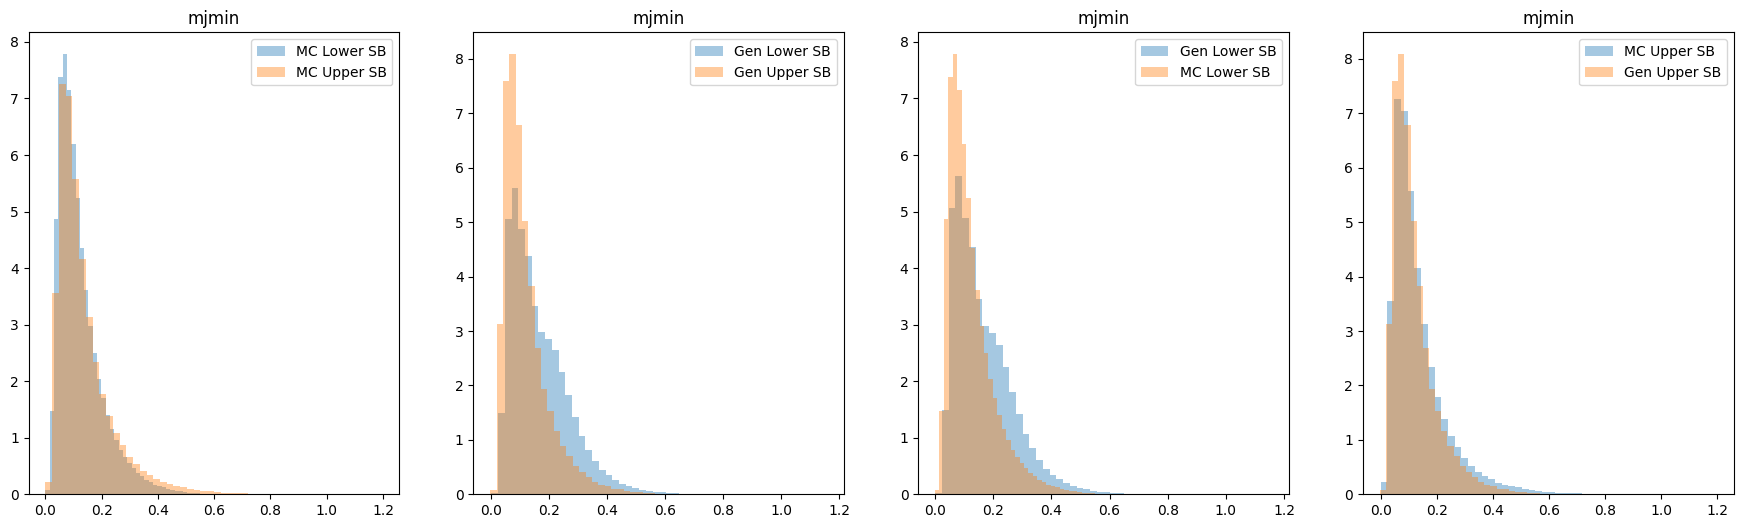

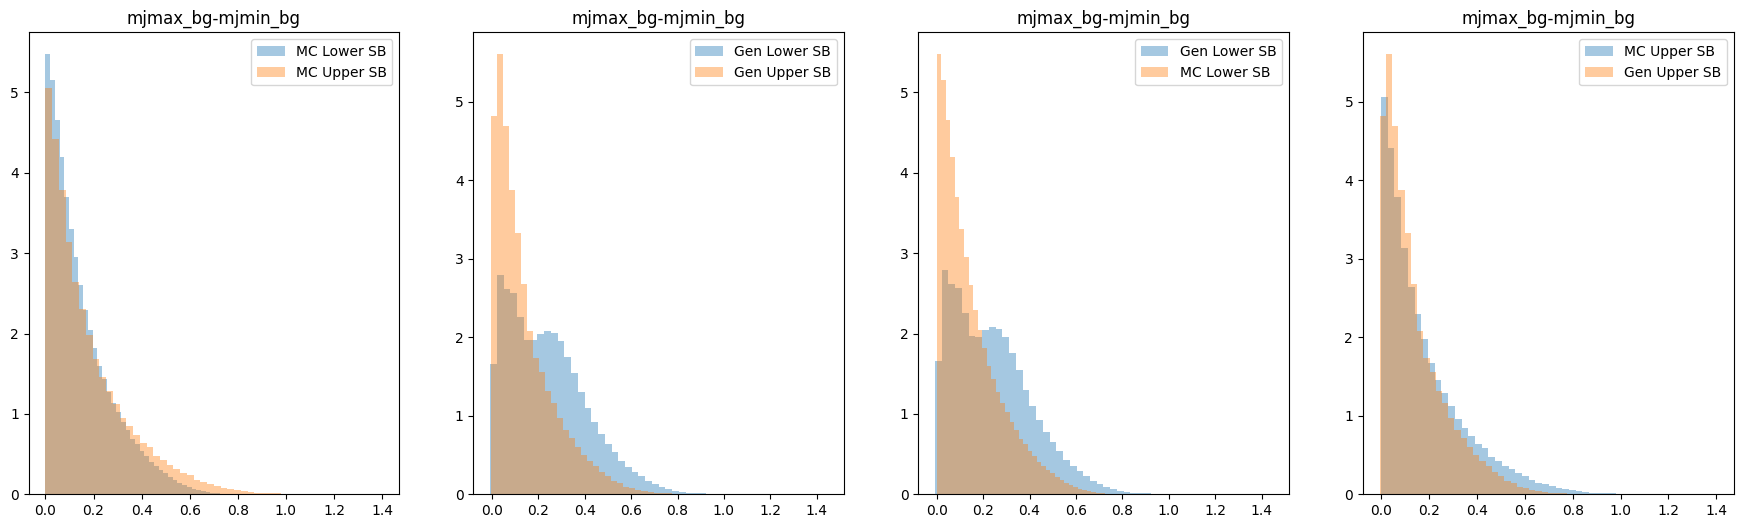

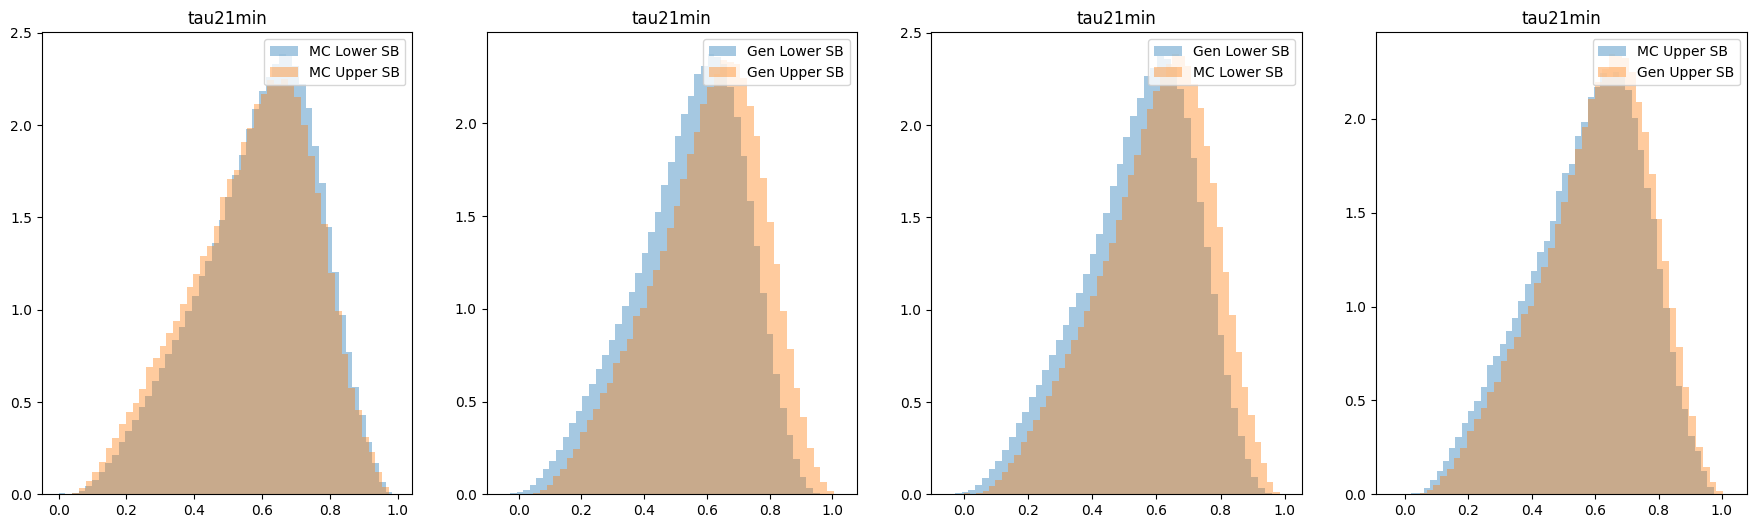

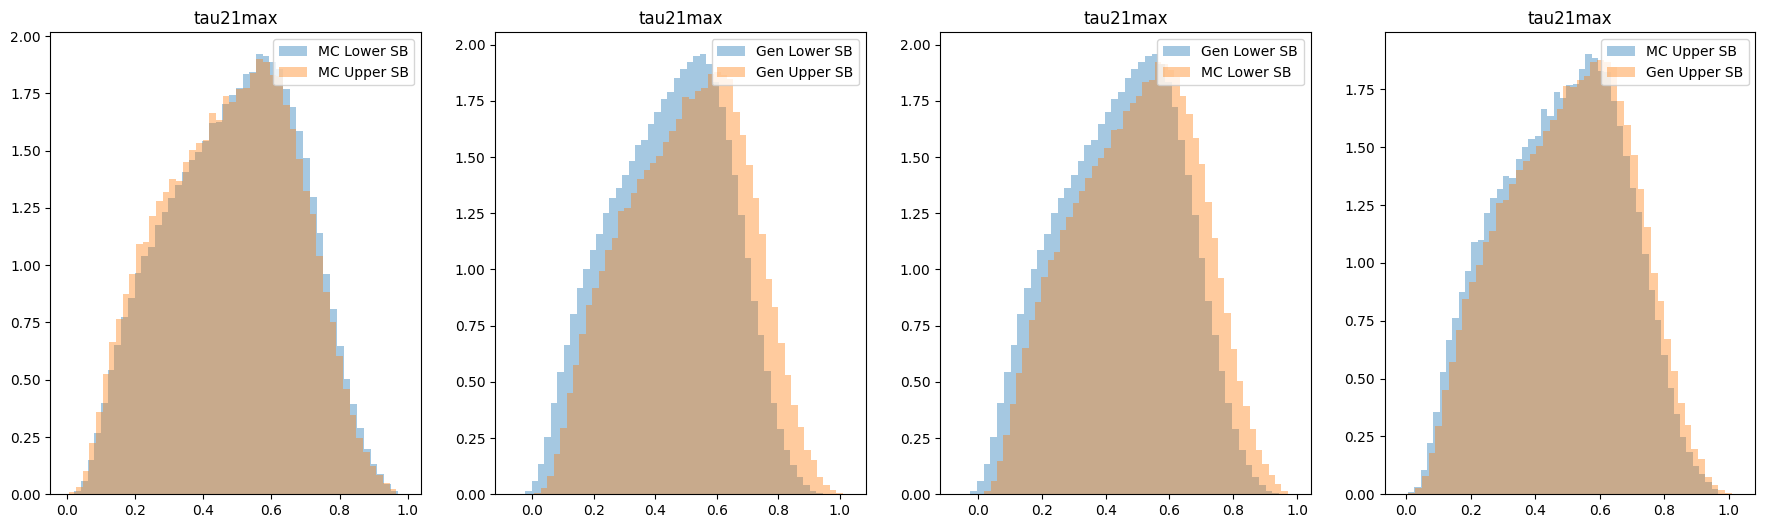

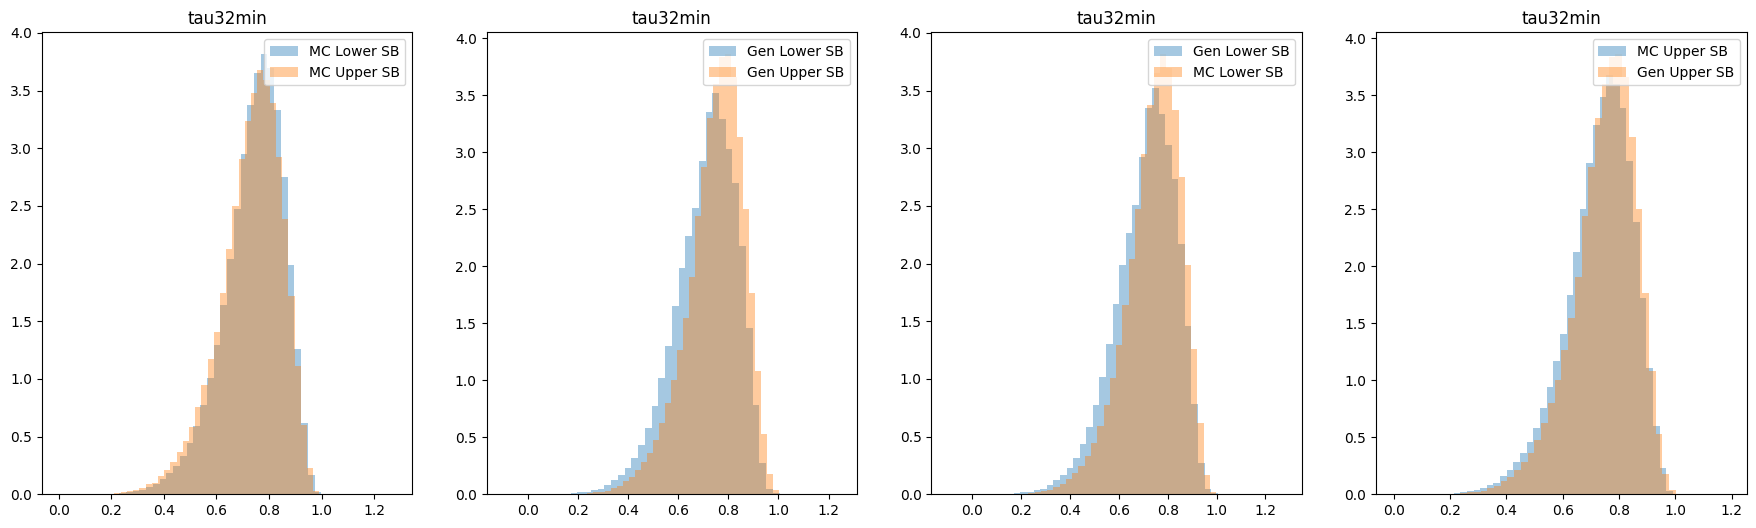

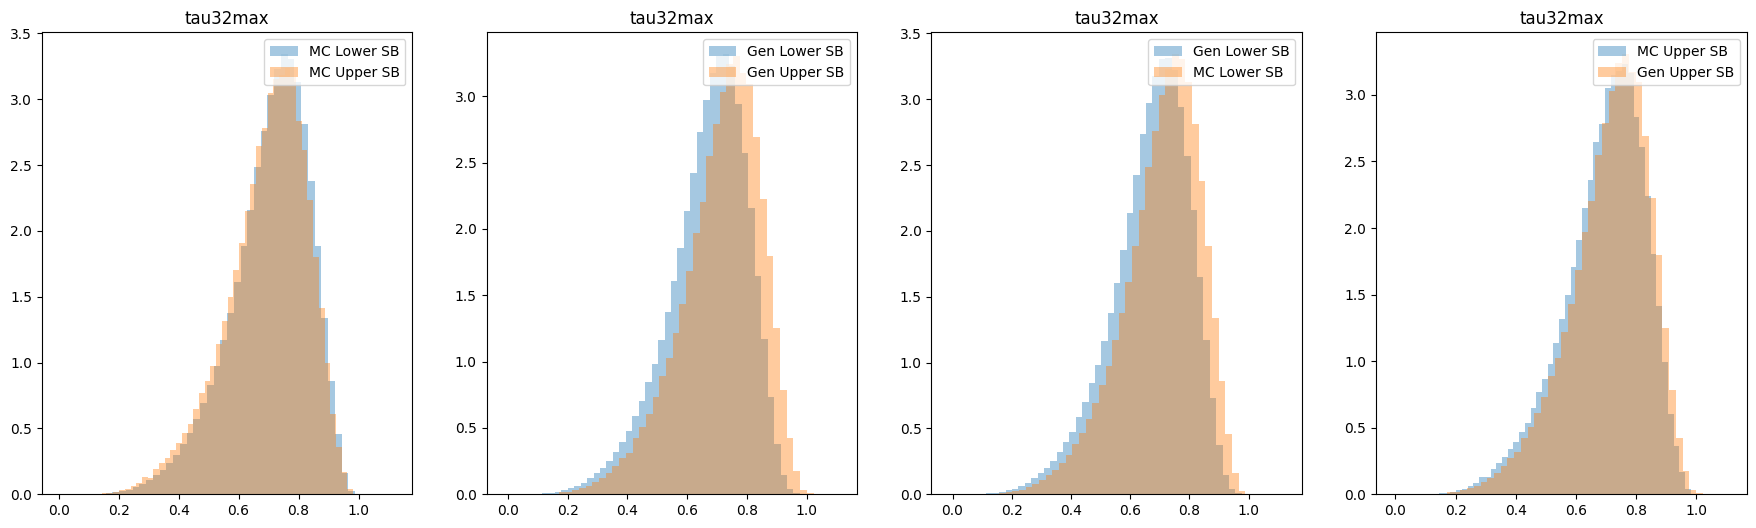

In [3]:
gen_upperSB_data = np.load("outputs/gen_dataset/cVAEz6_03-28-2023/LHCO2020_cB-VAE_events_UpperSB.npy")
gen_lowerSB_data = np.load("outputs/gen_dataset/cVAEz6_03-28-2023/LHCO2020_cB-VAE_events_LowerSB.npy")


for i in range(6):
    plt.figure(figsize=(22,6))
    
    plt.subplot(1,4,1)
    plt.hist(data[cond_data<=3.3,i], bins=50, alpha=0.4, label='MC Lower SB', density=True)
    plt.hist(data[cond_data>=3.7,i], bins=50, alpha=0.4, label='MC Upper SB', density=True)
    plt.legend(loc='upper right')
    plt.title(train_features[i])

    plt.subplot(1,4,2)
    plt.hist(gen_lowerSB_data[:,i], bins=50, alpha=0.4, label='Gen Lower SB', density=True)
    plt.hist(gen_upperSB_data[:,i], bins=50, alpha=0.4, label='Gen Upper SB', density=True)
    plt.legend(loc='upper right')
    plt.title(train_features[i])

    plt.subplot(1,4,3)
    plt.hist(gen_lowerSB_data[:,i], bins=50, alpha=0.4, label='Gen Lower SB', density=True)
    plt.hist(data[cond_data<=3.3,i], bins=50, alpha=0.4, label='MC Lower SB', density=True)
    plt.legend(loc='upper right')
    plt.title(train_features[i])

    plt.subplot(1,4,4)
    plt.hist(data[cond_data>=3.7,i], bins=50, alpha=0.4, label='MC Upper SB', density=True)
    #plt.hist(data[:,i], bins=50, alpha=0.4, label='MC Upper SB', density=True)
    plt.hist(gen_upperSB_data[:,i], bins=50, alpha=0.4, label='Gen Upper SB', density=True)
    plt.legend(loc='upper right')
    plt.title(train_features[i])

    plt.show()


/tmp/ipykernel_227848/1803195814.py:7: RuntimeWarning: invalid value encountered in true_divide
  ratio = hist1 / hist2


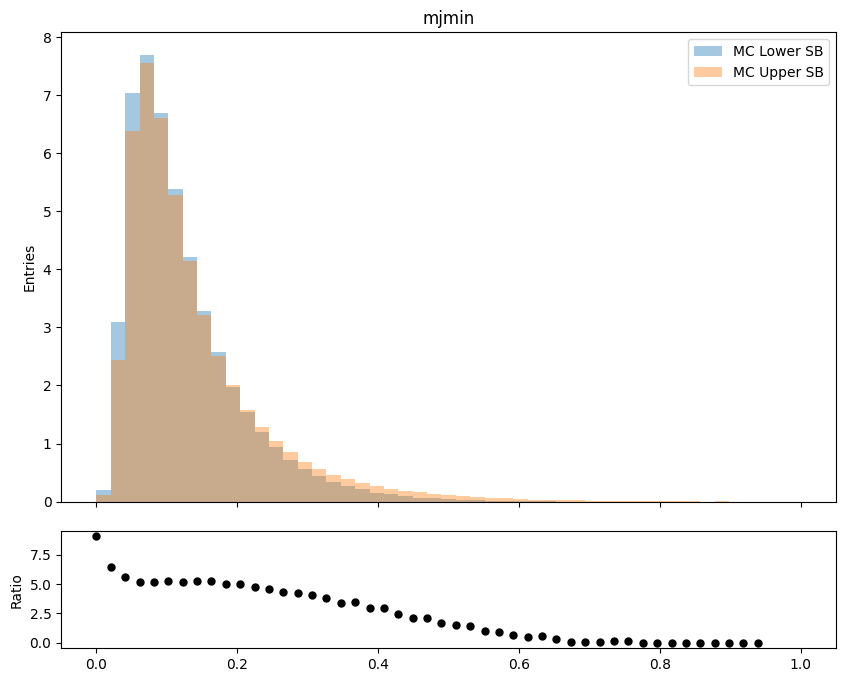

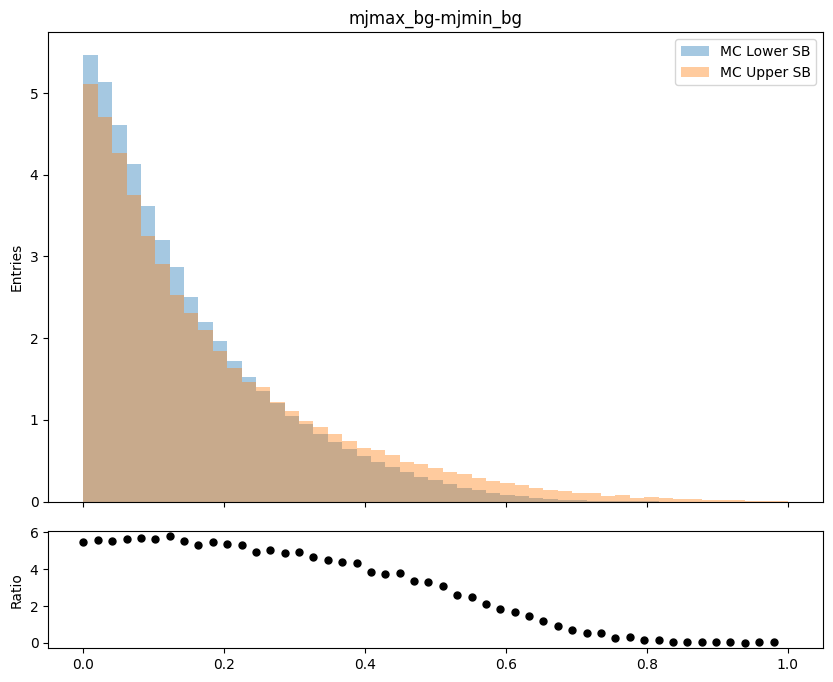

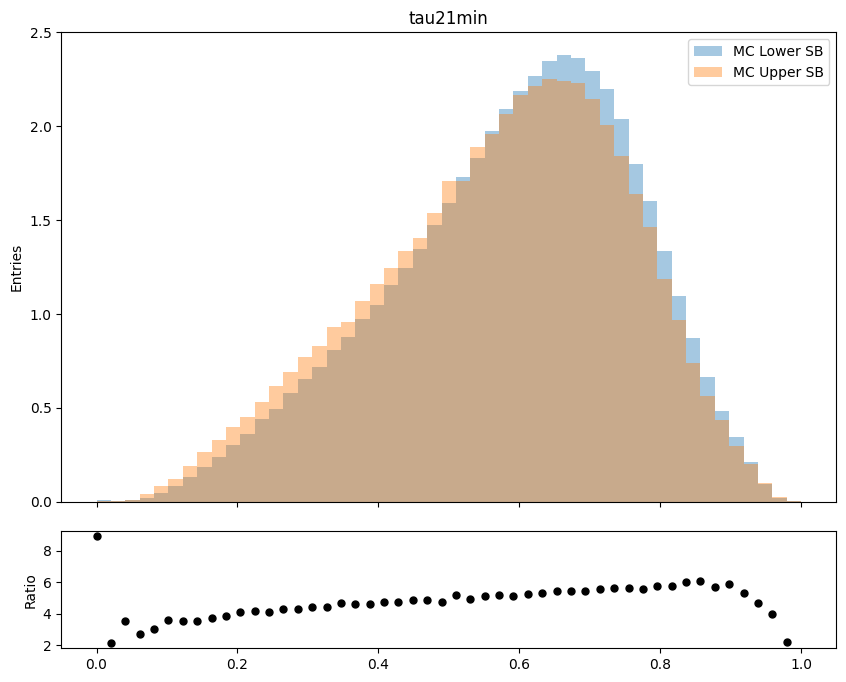

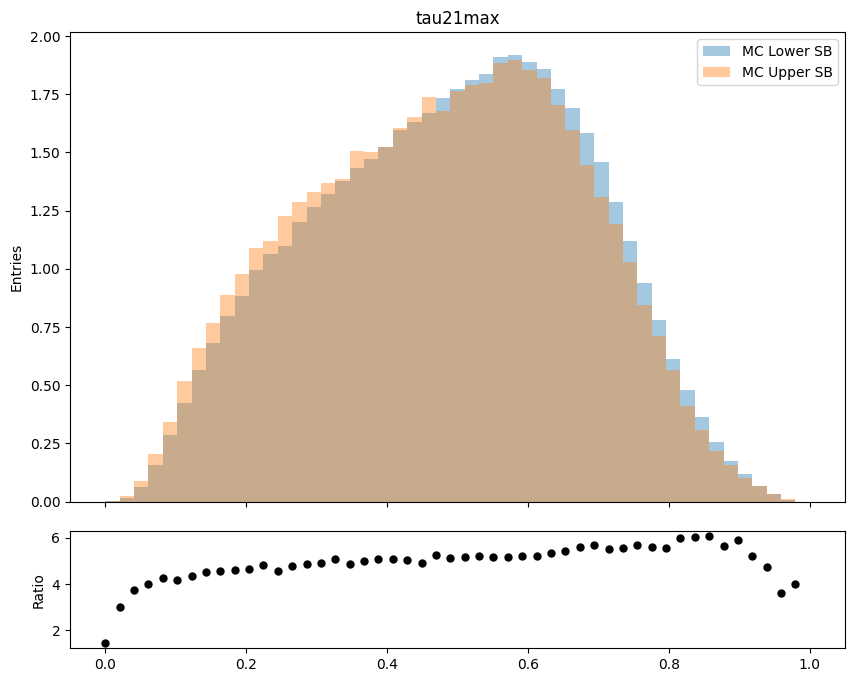

/tmp/ipykernel_227848/1803195814.py:7: RuntimeWarning: divide by zero encountered in true_divide
  ratio = hist1 / hist2


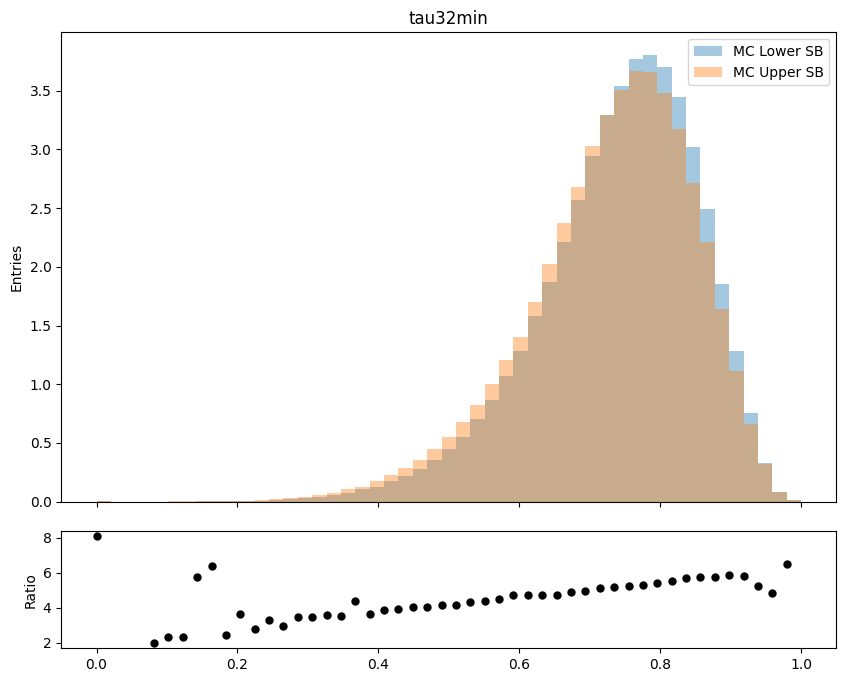

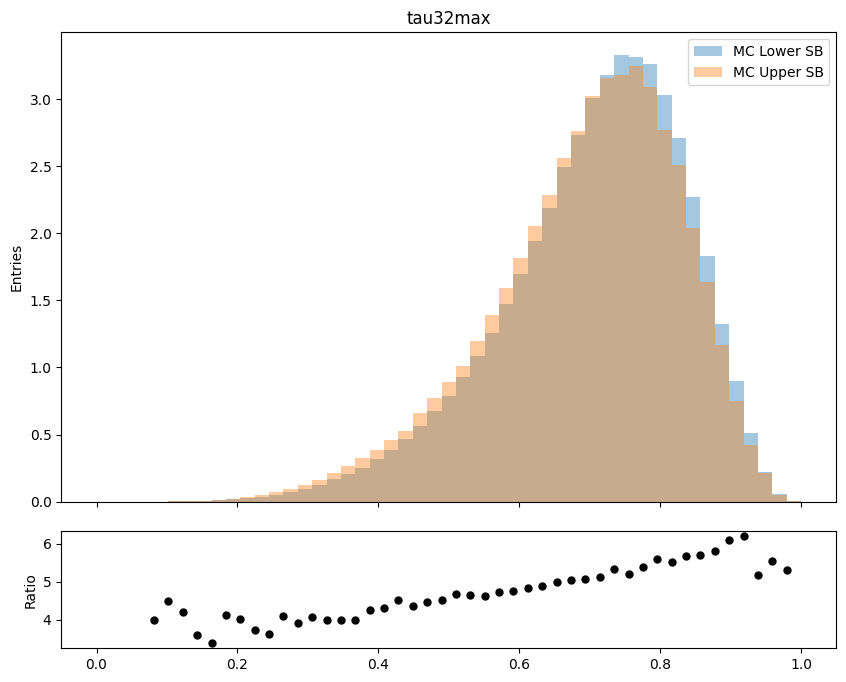

In [4]:

for i in range(6):
    # Plot the histograms in the first subplot
    bins = np.linspace(0, 1, 50)
    hist1, _ = np.histogram(data[cond_data<3.3,i], bins=bins)
    hist2, _ = np.histogram(data[cond_data>3.7,i], bins=bins)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)
    ratio = hist1 / hist2
    ax1.hist(data[cond_data<3.3,i], bins=bins, alpha=0.4, label='MC Lower SB', density=True)
    ax1.hist(data[cond_data>3.7,i], bins=bins, alpha=0.4, label='MC Upper SB', density=True)
    # Plot the ratio of the histograms in the second subplot
    # ax2.bar(bins[:-1], ratio, width=(bins[1]-bins[0]))
    ax2.errorbar(bins[:-1], ratio, fmt='o', markersize=5, capsize=3, color='black')
    ax1.set_ylabel('Entries')
    ax2.set_ylabel('Ratio')
    ax1.set_title(train_features[i])
    ax1.legend(loc='upper right')
    # Adjust the spacing between the subplots
    plt.subplots_adjust(hspace=0.1)


    plt.show()


/tmp/ipykernel_227848/583448871.py:38: RuntimeWarning: divide by zero encountered in true_divide
  ratio2 = hist2 / hist4
/tmp/ipykernel_227848/583448871.py:38: RuntimeWarning: invalid value encountered in true_divide
  ratio2 = hist2 / hist4
/tmp/ipykernel_227848/583448871.py:41: RuntimeWarning: divide by zero encountered in true_divide
  ratio_err2 = np.sqrt((1/hist4)**2 * np.sum((hist2/hist4**2)**2))
/tmp/ipykernel_227848/583448871.py:41: RuntimeWarning: invalid value encountered in true_divide
  ratio_err2 = np.sqrt((1/hist4)**2 * np.sum((hist2/hist4**2)**2))
/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


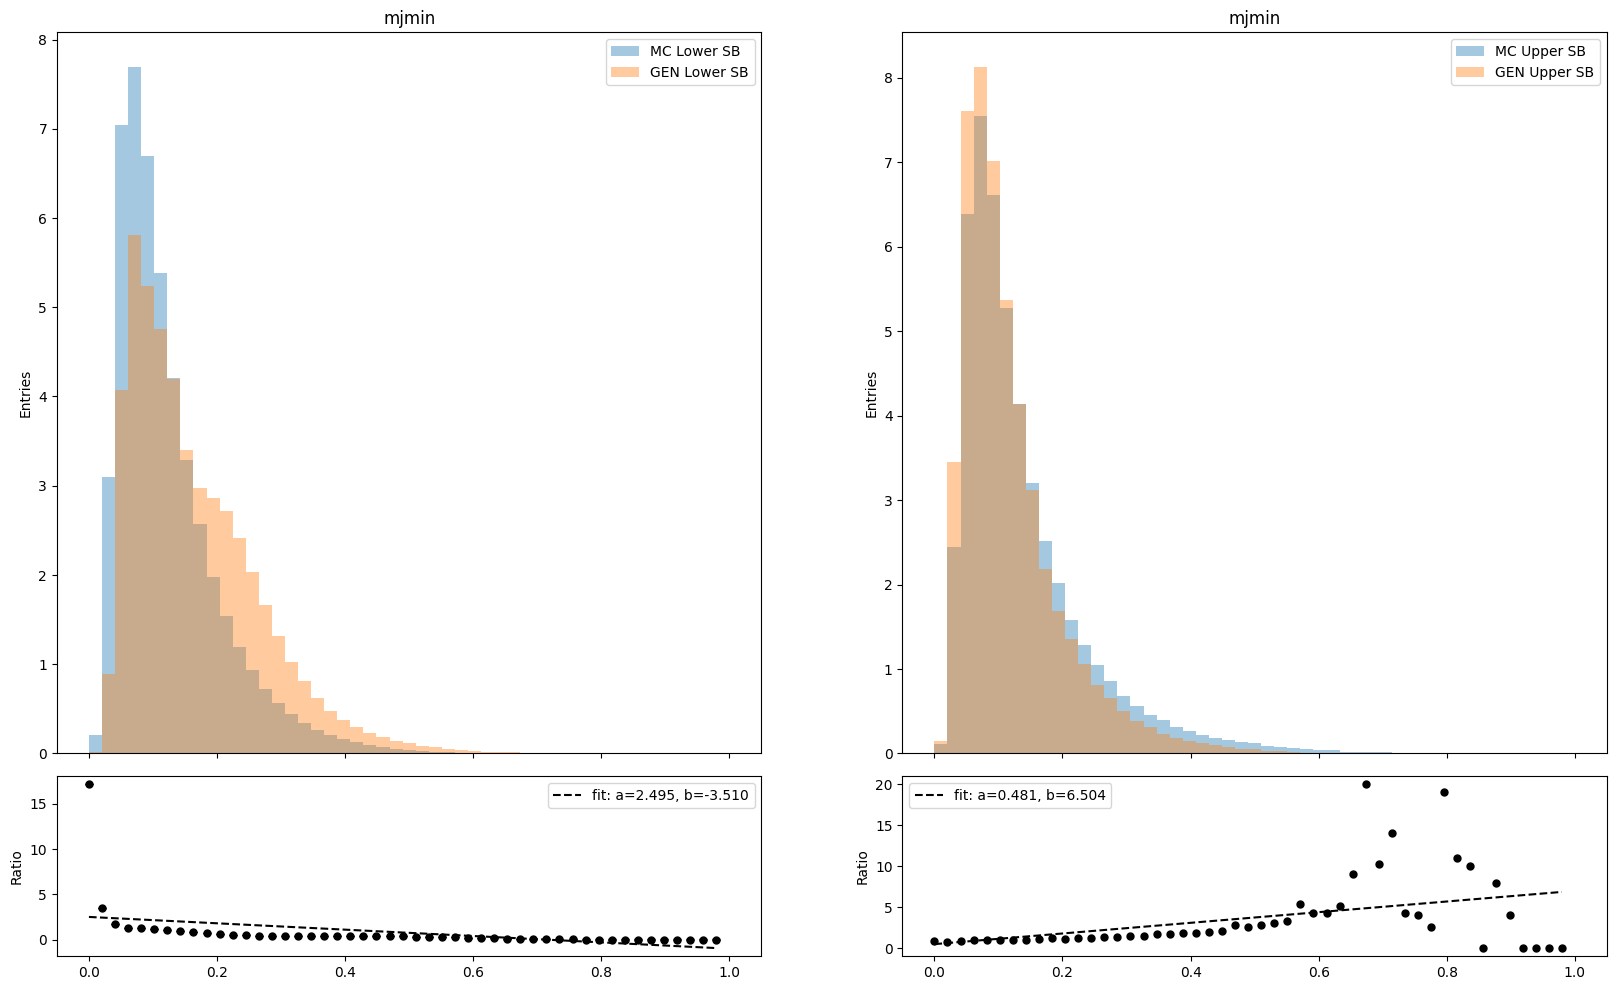

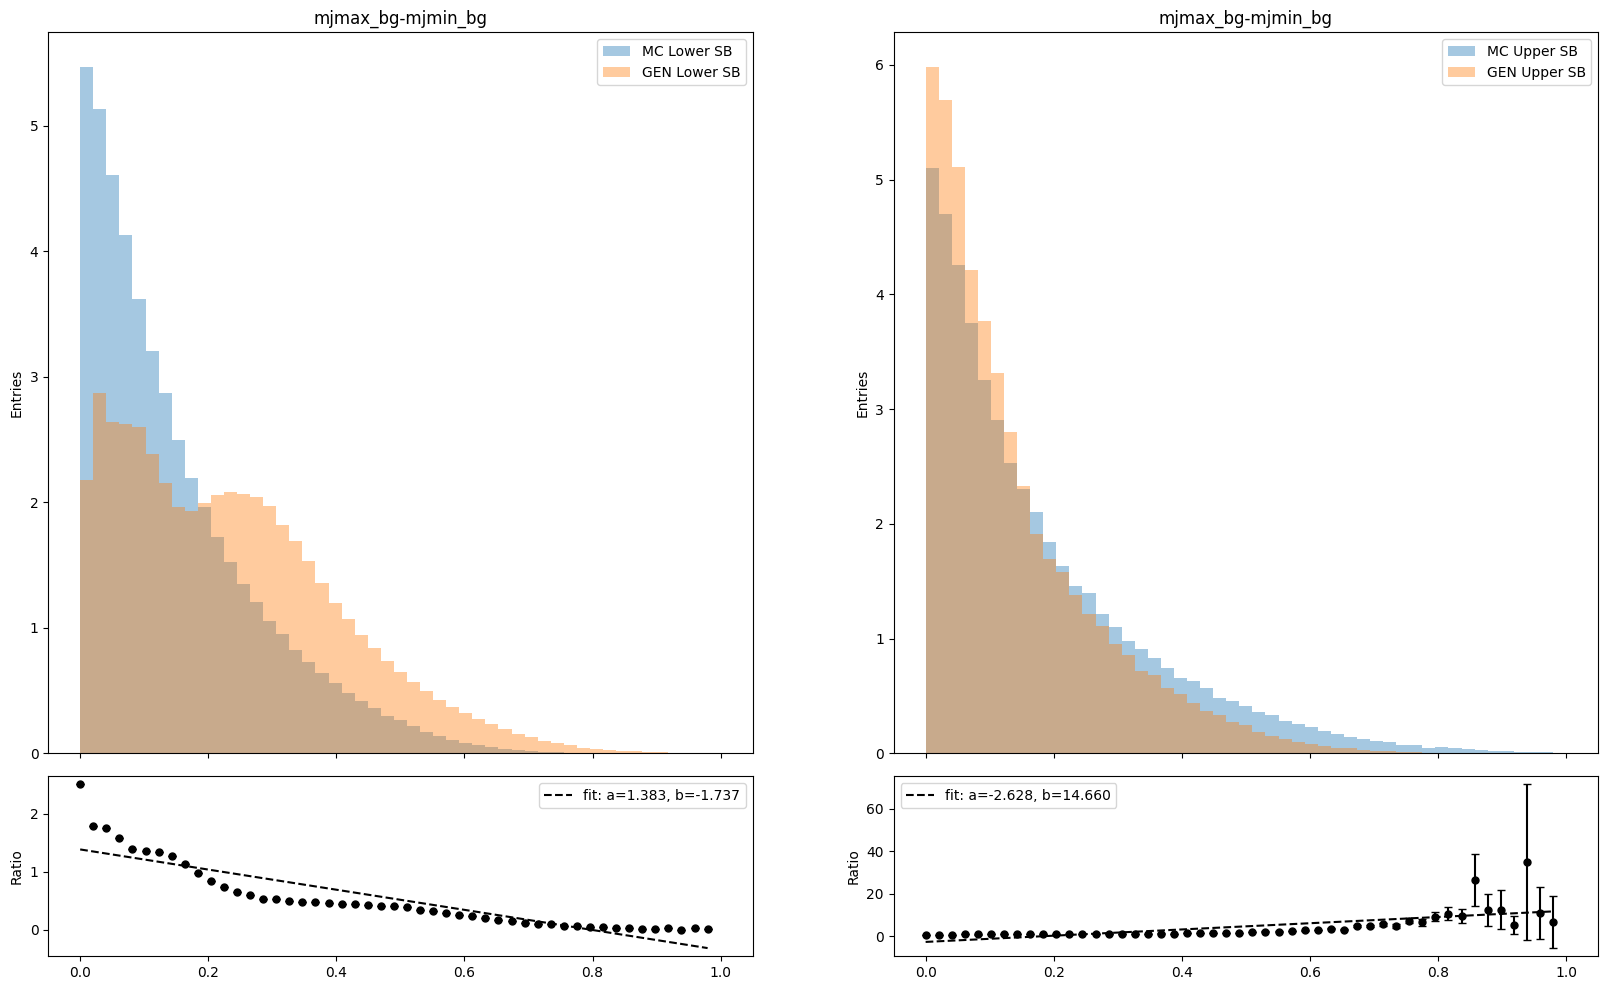

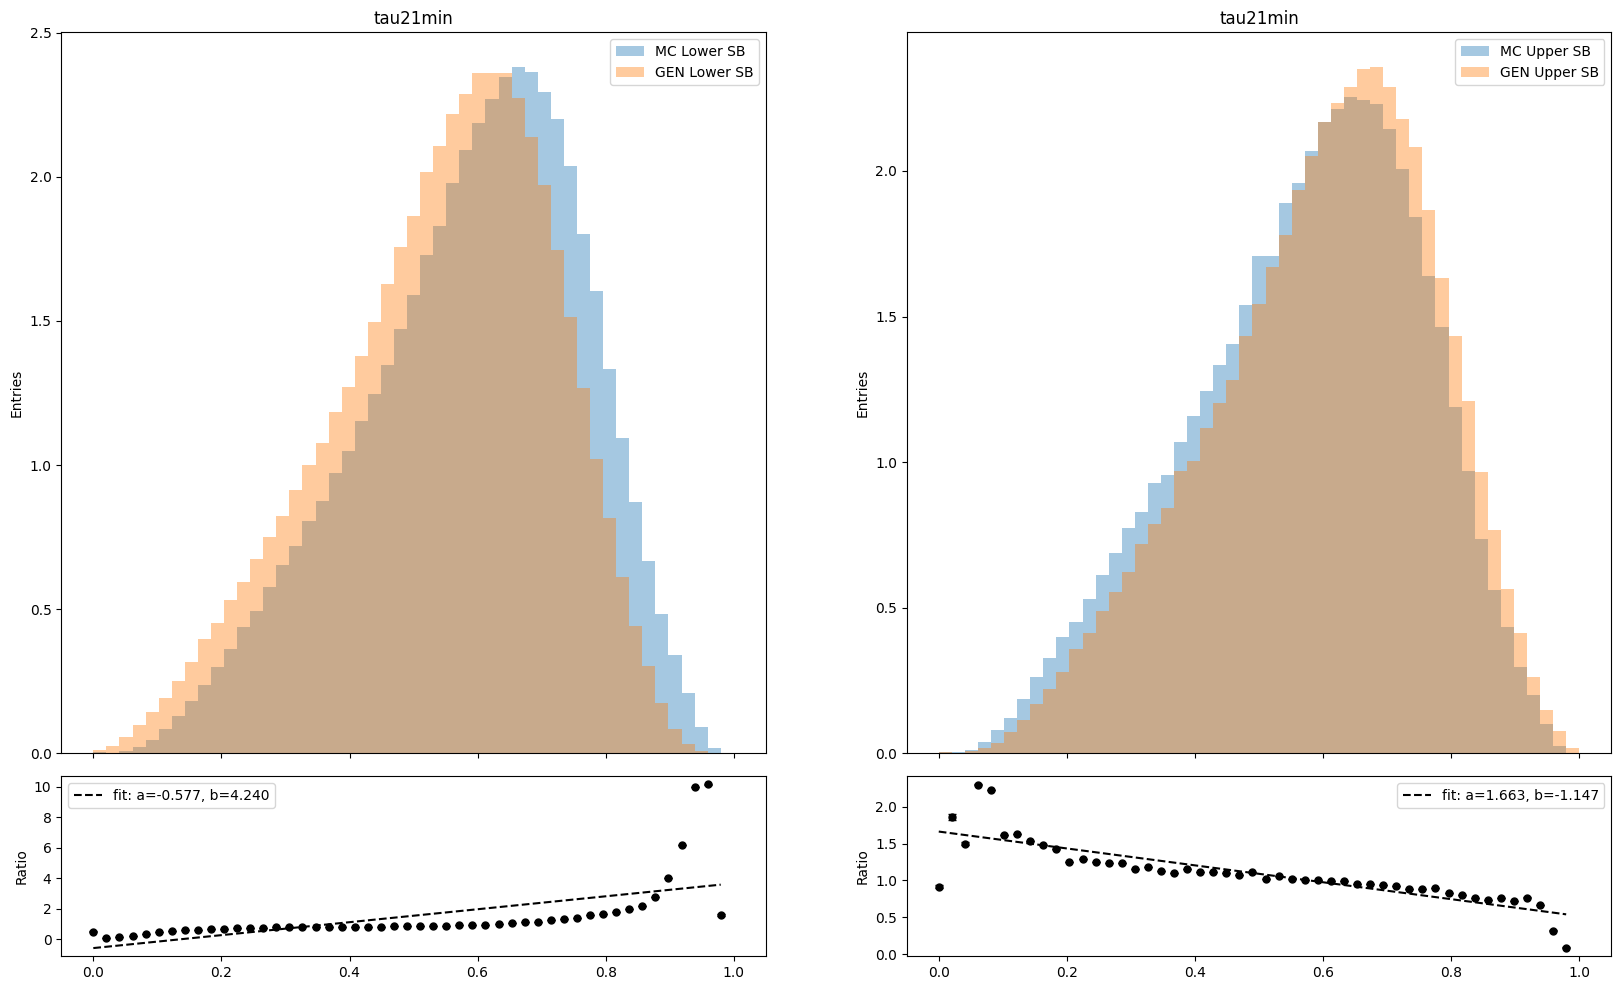

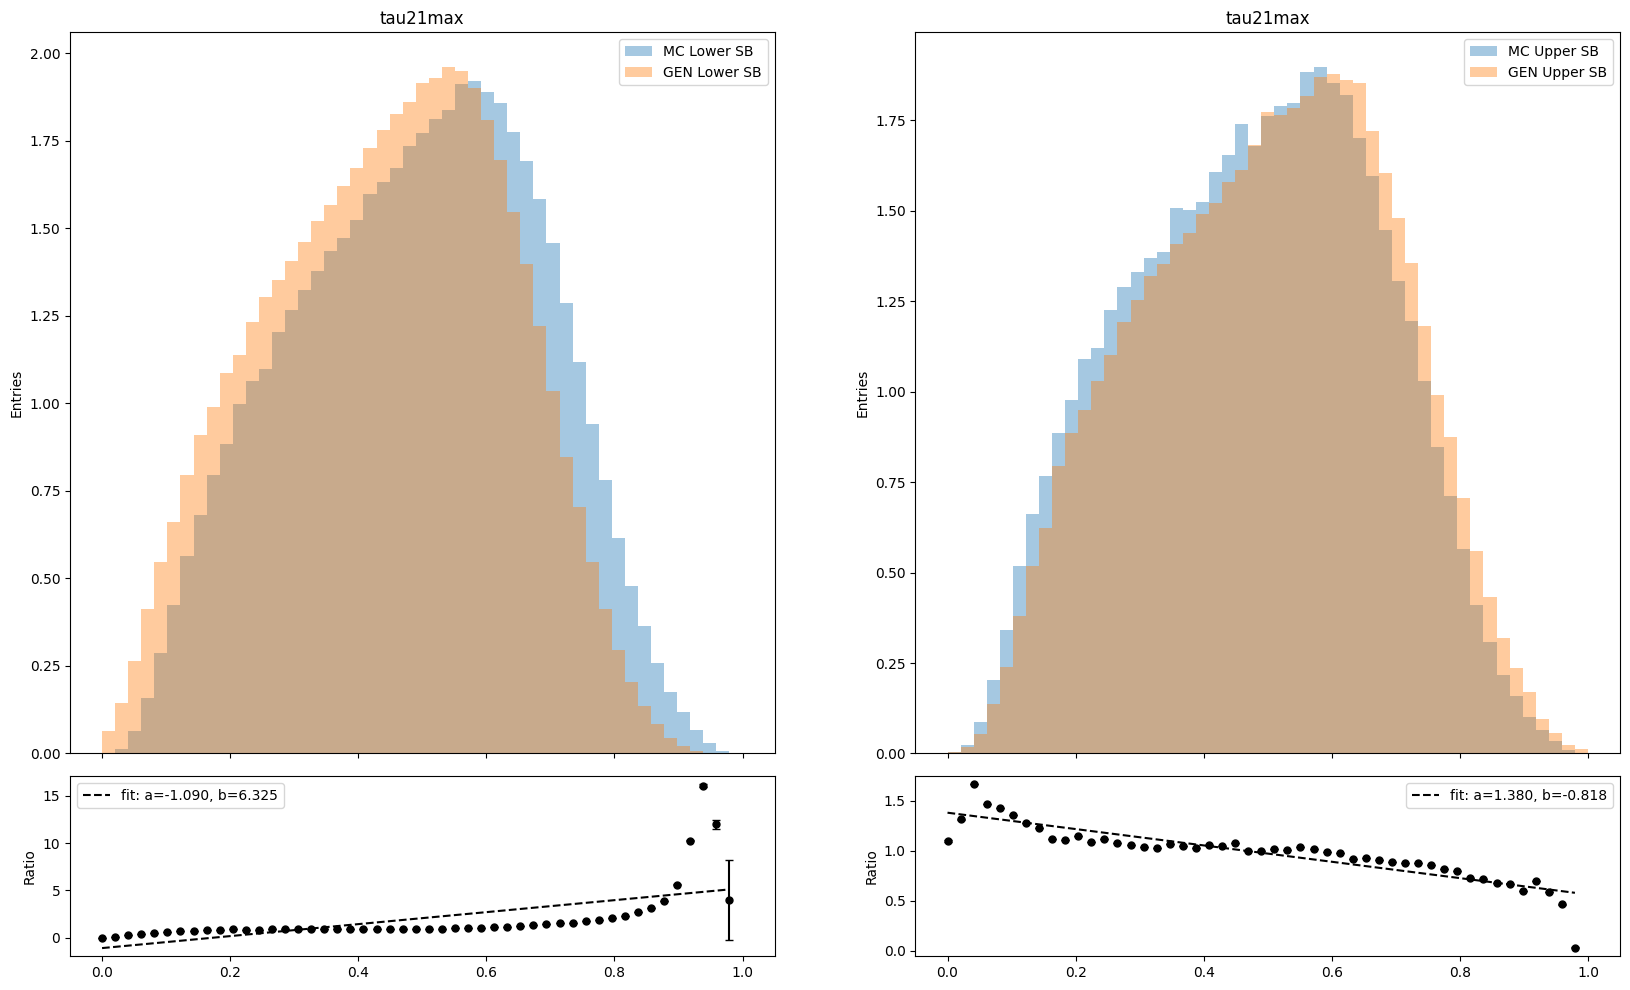

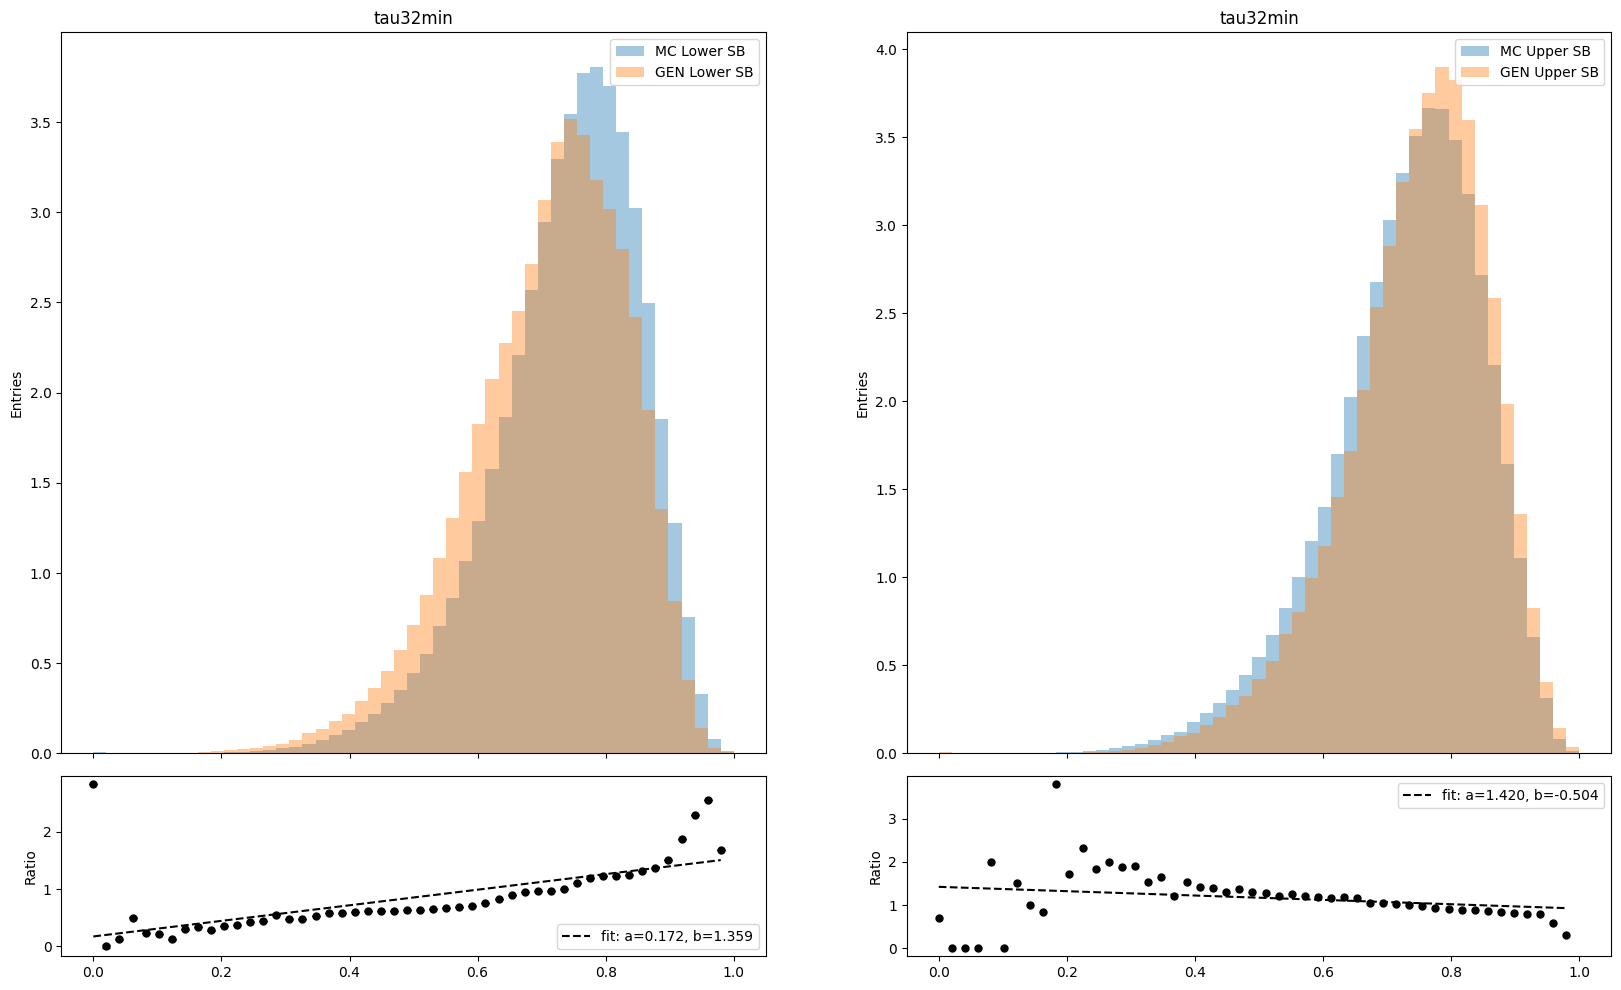

/tmp/ipykernel_227848/583448871.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ratio = hist1 / hist3
/tmp/ipykernel_227848/583448871.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_err = np.sqrt((1/hist3)**2 * np.sum((hist1/hist3**2)**2))


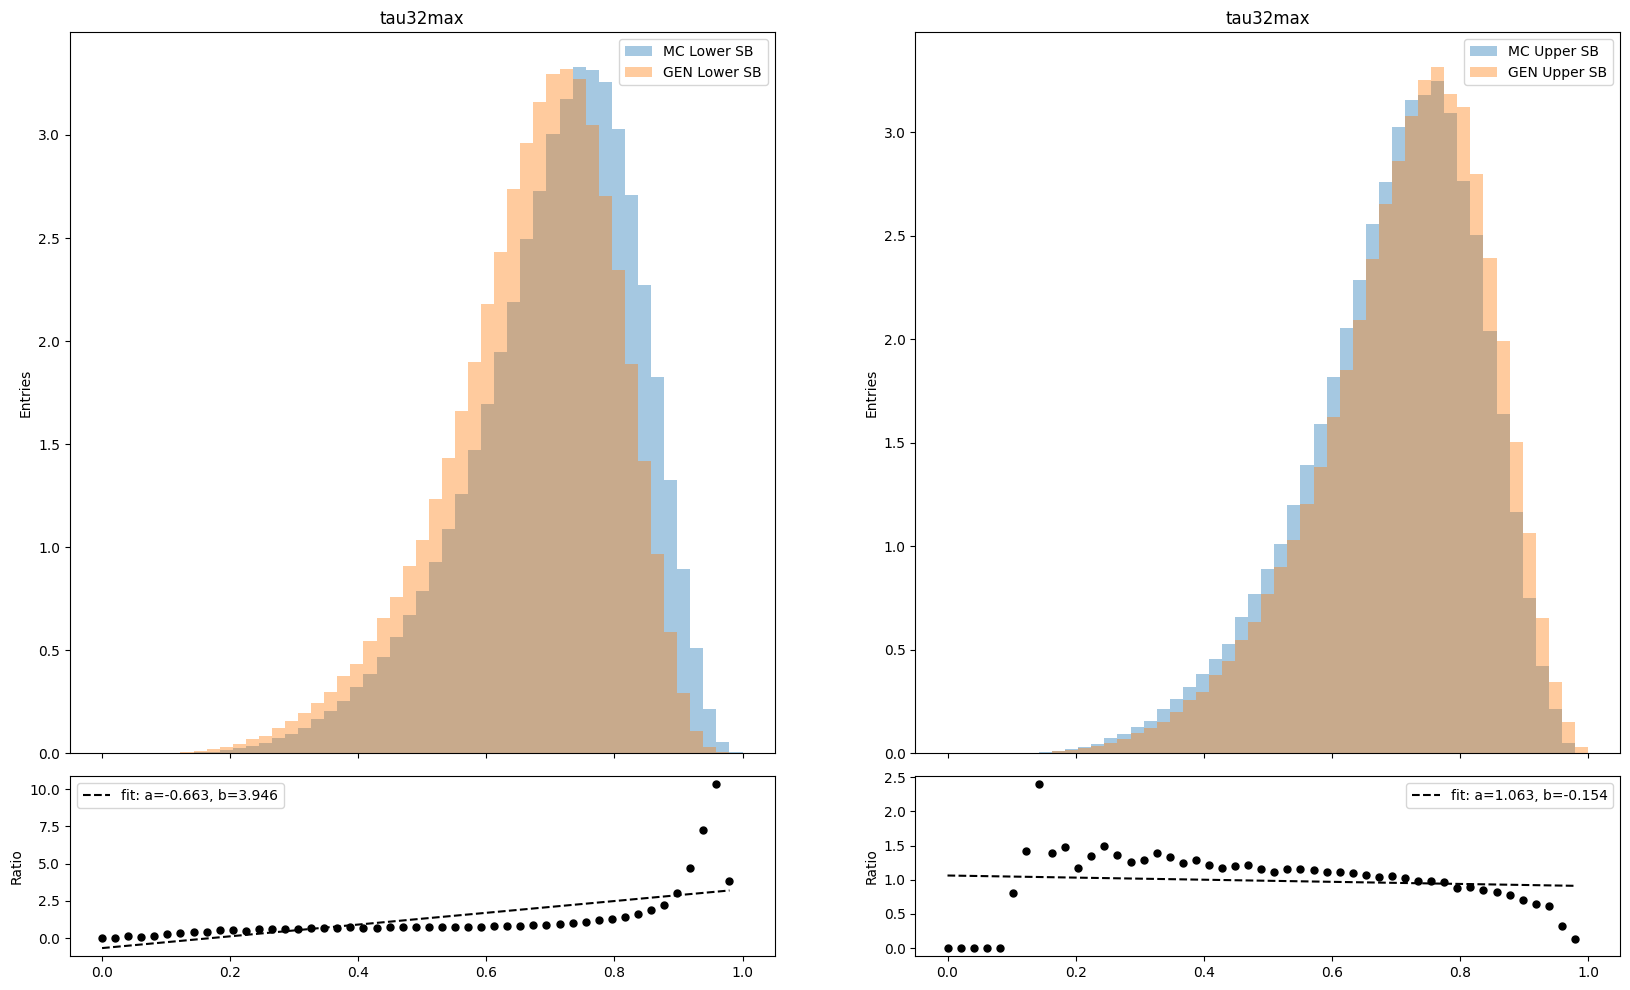

In [5]:
def func(x, a, b):
    return a + b*x
# Create the histograms
for i in range(6):    
    bins = np.linspace(0, 1, 50)
    hist1, _ = np.histogram(data[cond_data<3.3,i], bins=bins)
    hist2, _ = np.histogram(data[cond_data>3.7,i], bins=bins)
    hist3, _ = np.histogram(gen_lowerSB_data[:,i], bins=bins)
    hist4, _ = np.histogram(gen_upperSB_data[:,i], bins=bins)

    # Create a new figure with a 2 by 2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Calculate the ratio of the histograms
    ratio = hist1 / hist3
    # we want to avoinf the divide by zero encountered error so we use np.where to get rid of zeros and infinities
    ratio = np.where(np.isnan(ratio) | np.isinf(ratio), 0, ratio)
    # ratio_err = ratio * np.sqrt(1/hist1 + 1/hist3)
    ratio_err = np.sqrt((1/hist3)**2 * np.sum((hist1/hist3**2)**2))
    # Plot the histograms in the first subplot and label them
    axs[0, 0].hist(data[cond_data<3.3,i], bins=bins, alpha=0.4, label='MC Lower SB', density=True)
    axs[0, 0].hist(gen_lowerSB_data[:,i], bins=bins, alpha=0.4, label='GEN Lower SB', density=True)
    # Plot the ratio of the histograms in the second subplot with error bars
    axs[1, 0].errorbar(bins[:-1], ratio, yerr=ratio_err, fmt='o', markersize=5, capsize=3, color='black')
    popt, pcov = curve_fit(func, bins[:-1], ratio)
    axs[1, 0].plot(bins[:-1], func(bins[:-1], *popt), 'k--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    axs[1, 0].legend()
    #labels
    axs[0, 0].set_ylabel('Entries')
    axs[1, 0].set_ylabel('Ratio')
    axs[0, 0].set_title(train_features[i])
    axs[0, 0].legend(loc='upper right')
    # Adjust the spacing between the subplots
    plt.subplots_adjust(hspace=0.1)

    #now for upper SB
    # Calculate the ratio of the histograms
    ratio2 = hist2 / hist4
    ratio2 = np.where(np.isnan(ratio2) | np.isinf(ratio2), 0, ratio2)
    # ratio_err2 = ratio * np.sqrt(1/hist2 + 1/hist4)
    ratio_err2 = np.sqrt((1/hist4)**2 * np.sum((hist2/hist4**2)**2))
    # Plot the histograms in the first subplot and label them
    axs[0, 1].hist(data[cond_data>3.7,i], bins=bins, alpha=0.4, label='MC Upper SB', density=True)
    axs[0, 1].hist(gen_upperSB_data[:,i], bins=bins, alpha=0.4, label='GEN Upper SB', density=True)
    # Plot the ratio of the histograms in the second subplot with error bars
    axs[1, 1].errorbar(bins[:-1], ratio2, yerr=ratio_err2, fmt='o', markersize=5, capsize=3, color='black')
    #we also want to draw a linear fit of the points in thr errorbar plot. here is the code for the fit and plotting of it
    popt, pcov = curve_fit(func, bins[:-1], ratio2)
    axs[1, 1].plot(bins[:-1], func(bins[:-1], *popt), 'k--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    axs[1, 1].legend()
    #labels
    axs[0, 1].set_ylabel('Entries')
    axs[1, 1].set_ylabel('Ratio')
    axs[0, 1].set_title(train_features[i])
    axs[0, 1].legend(loc='upper right')

    # Adjust the spacing between the subplots
    plt.subplots_adjust(hspace=0.05)

    plt.show()


In [13]:
# fileSR = '/global/homes/a/agarabag/LHCO2020-cVAE/data_save/LHCO2020_cB-VAE_events_6var_z6_NoF_SR.csv'
# fileSB = '/global/homes/a/agarabag/LHCO2020-cVAE/data_save/LHCO2020_cB-VAE_events_6var_z6_NoF_SB.csv'

# scaled_linear_vae_gen_SR = pd.read_csv(fileSR, delimiter = ' ', header=None, index_col=False)
# scaled_linear_vae_gen_SR = scaled_linear_vae_gen_SR.to_numpy()

# scaled_linear_vae_gen_SB = pd.read_csv(fileSB, delimiter = ' ', header=None, index_col=False)
# scaled_linear_vae_gen_SB = scaled_linear_vae_gen_SB.to_numpy()

# print(scaled_linear_vae_gen_SR.shape)

# # plot first feature of scaled_linear_vae_gen_SR
# plt.hist(scaled_linear_vae_gen_SR[:,0], bins=50, alpha=0.4, label='SR', density=True)
# plt.hist(scaled_linear_vae_gen_SB[:,0], bins=50, alpha=0.4, label='SB', density=True)
# plt.legend(loc='upper right')
# plt.show()


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [5]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [6]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [7]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend()
        plt.yscale('log')


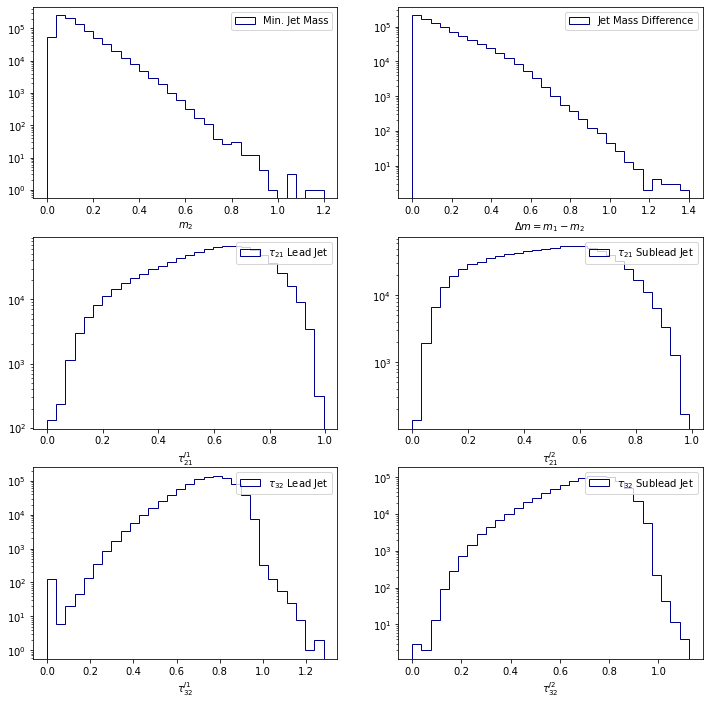

In [8]:
plot_variables(data)